In [53]:
import numpy as np
import pandas as pd
import random
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import time
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

In [8]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [29]:
df=pd.DataFrame(X)
df['MONTH_']=[random.choice(np.array(['2018-09-30T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000',
       '2019-03-31T00:00:00.000000000'])).astype('datetime64[ns]') for i in range(len(X))]
df.sort_values(by=['MONTH_'],ascending=True,inplace=True)
df=df.reset_index(drop=True)
X=np.array(df.drop('MONTH_',axis=1)) #targets not sorted!!!

In [35]:
df[:65]

,0,1,2,3,MONTH_
0,6.3,3.4,5.6,2.4,2018-09-30
1,5.8,2.7,4.1,1.0,2018-09-30
2,6.1,2.6,5.6,1.4,2018-09-30
3,6.3,2.5,5.0,1.9,2018-09-30
4,7.3,2.9,6.3,1.8,2018-09-30
5,6.5,3.2,5.1,2.0,2018-09-30
6,6.2,2.8,4.8,1.8,2018-09-30
7,5.1,3.8,1.5,0.3,2018-09-30
8,4.7,3.2,1.6,0.2,2018-09-30
9,4.9,3.1,1.5,0.2,2018-09-30


In [31]:
X

array([[6.3, 3.4, 5.6, 2.4],
       [5.8, 2.7, 4.1, 1. ],
       [6.1, 2.6, 5.6, 1.4],
       [6.3, 2.5, 5. , 1.9],
       [7.3, 2.9, 6.3, 1.8],
       [6.5, 3.2, 5.1, 2. ],
       [6.2, 2.8, 4.8, 1.8],
       [5.1, 3.8, 1.5, 0.3],
       [4.7, 3.2, 1.6, 0.2],
       [4.9, 3.1, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [6.4, 3.2, 5.3, 2.3],
       [7.2, 3.6, 6.1, 2.5],
       [4.9, 3.6, 1.4, 0.1],
       [5.4, 3.4, 1.5, 0.4],
       [6.7, 2.5, 5.8, 1.8],
       [5.1, 3.7, 1.5, 0.4],
       [5.7, 2.6, 3.5, 1. ],
       [5.7, 4.4, 1.5, 0.4],
       [6.1, 2.8, 4. , 1.3],
       [6.3, 2.5, 4.9, 1.5],
       [4.5, 2.3, 1.3, 0.3],
       [5. , 3.3, 1.4, 0.2],
       [7.2, 3.2, 6. , 1.8],
       [5.4, 3.7, 1.5, 0.2],
       [6.4, 2.8, 5.6, 2.1],
       [7.7, 2.6, 6.9, 2.3],
       [7.7, 3. , 6.1, 2.3],
       [6.9, 3.2, 5.7, 2.3],
       [4.4, 3.2, 1.3, 0.2],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.9, 0.4],
       [5.9, 3. , 4.2, 1.5],
       [5.5, 3

In [32]:
def custom_cv(X):
   
    n=X.shape[0]
    i=2
    while i<=6:
        train_ind=df[np.in1d(np.array(df.MONTH_),df.MONTH_.unique()[:i])].index.tolist()
        test_ind=df[np.in1d(np.array(df.MONTH_),df.MONTH_.unique()[i:i+1])].index.tolist()
        yield train_ind,test_ind
        i+=1

In [33]:
for i,j in custom_cv(df):
    print(i)
    print(j)
    print('-----')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104,

In [36]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X, y, cv=custom_cv(df)).mean()
    print(current_score, params)
    return -current_score

In [83]:
space_xgb = {
            'n_estimators': 1000,#hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            # Increase this number if you have more cores. Otherwise, remove it and it will default
            # to the maxium number.
            'nthread': 4,
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1
        }

In [84]:
%%time
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)

0.10806100217864922                                                                                                    
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.30000000000000004, 'eval_metric': 'auc', 'gamma': 0.55, 'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}
0.12287581699346406                                                                                                    
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.025, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'max_depth': 1, 'min_child_weight': 4.0, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
0.09324618736383442                                                                                                    
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000

In [105]:
best

{'colsample_bytree': 0.7000000000000001,
 'eta': 0.225,
 'gamma': 0.6000000000000001,
 'max_depth': 12,
 'min_child_weight': 1.0,
 'subsample': 0.6000000000000001}

In [111]:
clf = XGBClassifier(**best)
clf.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7000000000000001, eta=0.225, eval_metric='auc',
              gamma=0.6000000000000001, learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1.0, missing=None,
              n_estimators=5000, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.6000000000000001)

In [108]:
#roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1])

In [91]:
clf.fit(X,y,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.7000000000000001, eta=0.225,
              gamma=0.6000000000000001, learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1.0, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.6000000000000001)

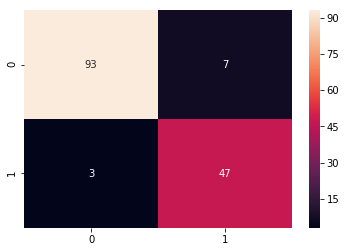

In [87]:
import seaborn as sn
sn.heatmap(multilabel_confusion_matrix(y, clf.predict(X))[0], annot=True)

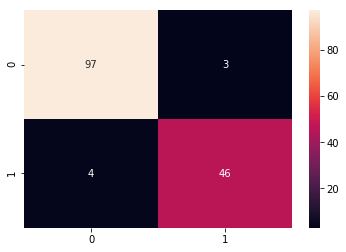

In [88]:
sn.heatmap(multilabel_confusion_matrix(y, clf.predict(X))[1], annot=True)

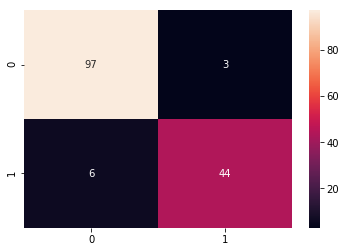

In [89]:
sn.heatmap(multilabel_confusion_matrix(y, clf.predict(X))[2], annot=True)